In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp

In [2]:
def compare(x_range, hue_range, hist_func, hue_label, boost=100):
    data = []
    for hue in hue_range:
        for x in x_range:
            hists = hist_func(x, hue)
            
            # analyse
            complexity = ep.measures(hists)['complexity']
            chi2, p, _, _ = sp.stats.chi2_contingency(hists)
            states = len(hists[0])
            cex = complexity*(states**2)*boost
            cep = 1 - sp.stats.chi2.cdf(cex, states)
            
            # store
            data.append({
                'c': cex,
                'chi2': chi2,
                'p': p,
                'cep': cep,
                'x': x,
                hue_label : hue,
            })

    plot(data, hue=hue_label)

def plot(data, x='x', hue='hue'):
    d = data[0].copy()
    del d[x]
    del d[hue]
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,10))
    df = pd.DataFrame(data)
    # chi2
    sns.lineplot(data=df, x=x, y='chi2', ax=axes[0][0], hue=hue)
    g = sns.lineplot(data=df, x=x, y='p', ax=axes[0][1], hue=hue, legend=False)
    axes[0][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05))
    
    # ce
    sns.lineplot(data=df, x=x, y='c', ax=axes[1][0], hue=hue, legend=False)
    g = sns.lineplot(data=df, x=x, y='cep', ax=axes[1][1], hue=hue, legend=False)
    axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05))

# Observations count

- C is invariant to the number of observations
- While for _p_ the fewer the observations, the less confident it is about being heterogenious 

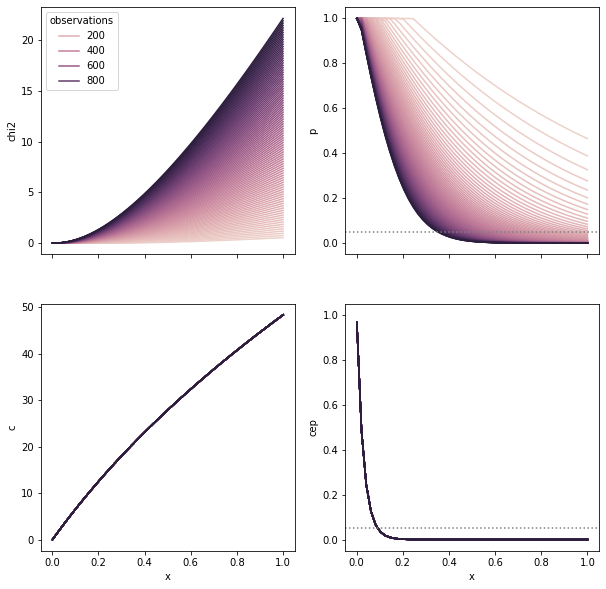

In [3]:
compare(np.linspace(0.001,1.0,50), range(50,1000,10), lambda x, h: np.array([[0.1,1],[0.1,1+x]])*h, 'observations')

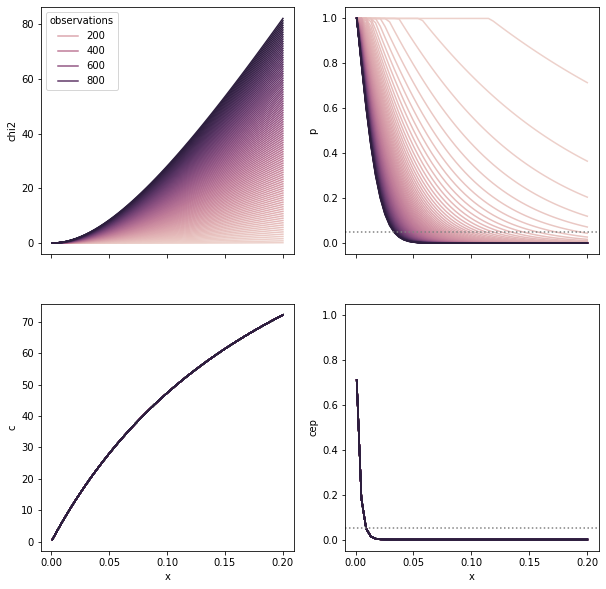

In [4]:
compare(np.linspace(0.001,0.2,50), range(10,1000,10), lambda x, h: np.array([[0.1,1],[0.1+x,1]])*h, 'observations')

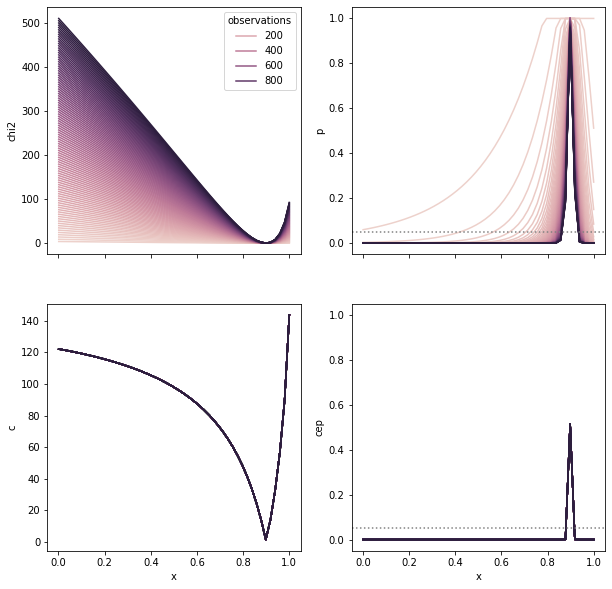

In [5]:
compare(np.linspace(0.001,1.0,50), range(10,1000,10), lambda x, h: np.array([[0.1,1],[1-x,1]])*h, 'observations')

# Ensembles

- C is largely invariant to the number of ensembles
- Chi2 heavily depends on it, as it fits into it's degrees of freedom
- But _p_ crosses at the 0.1 threshold at the same point, as it's interrepted in a similar way

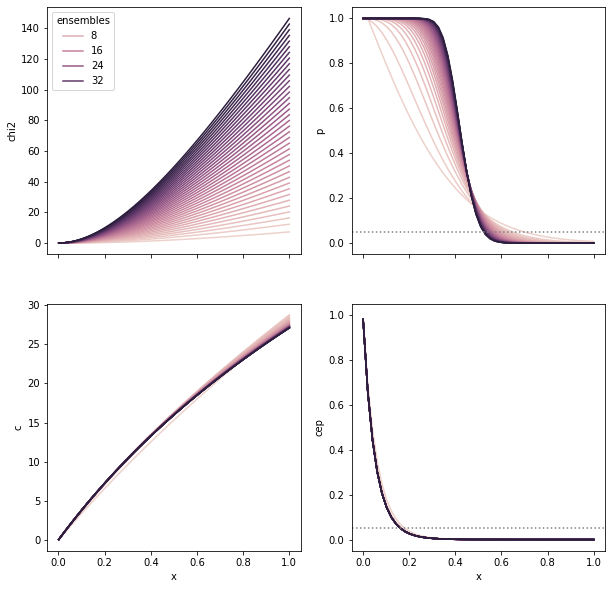

In [6]:
# Here i/N so that the total influence is normalised per ensemble
obs = 1000 # need to add this to compensate for above
compare(np.linspace(0.001,1.0,50), range(2,40), lambda x, h: np.array([[0.1,1+x*e/h] for e in range(h)])*obs, 'ensembles')

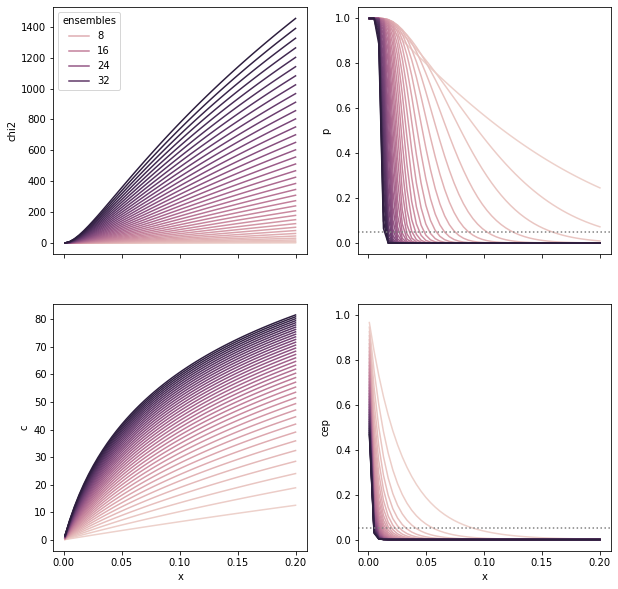

In [7]:
# Here it's just i, so the effect is amplified by the number of ensembles
obs = 1000 # need to add this to compensate for above
compare(np.linspace(0.001,0.2,50), range(2,40), lambda x, h: np.array([[0.1,1+x*e] for e in range(h)])*obs, 'ensembles')

# States

### More states with dimishing difference
- The fewer the states, the more significant the change
- C shows this as fewer states as being more heterogenious
- While _p_ does the same

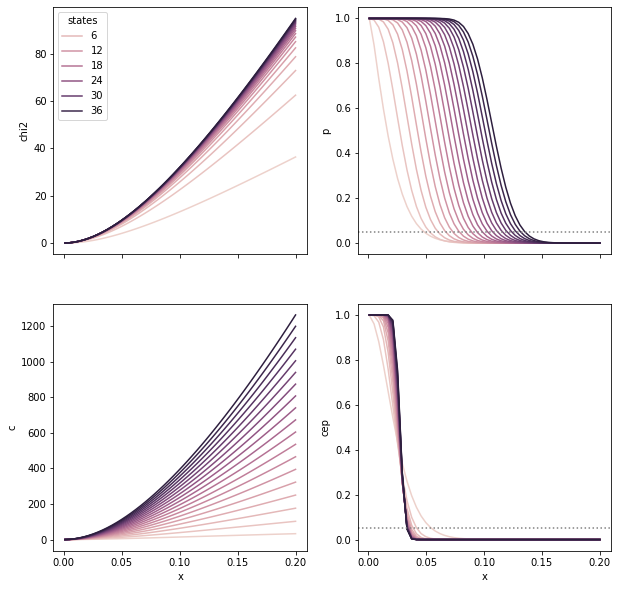

In [8]:
def state_hist(x, states):
    hists = np.array([np.ones(states)*0.1 for _ in range(2)])
    hists[1][1]+=x
    hists *= obs
    return hists

compare(np.linspace(0.001,0.2,50), range(2,40,2), state_hist, 'states')

### More states with a uniform difference
- increasing states makes the difference

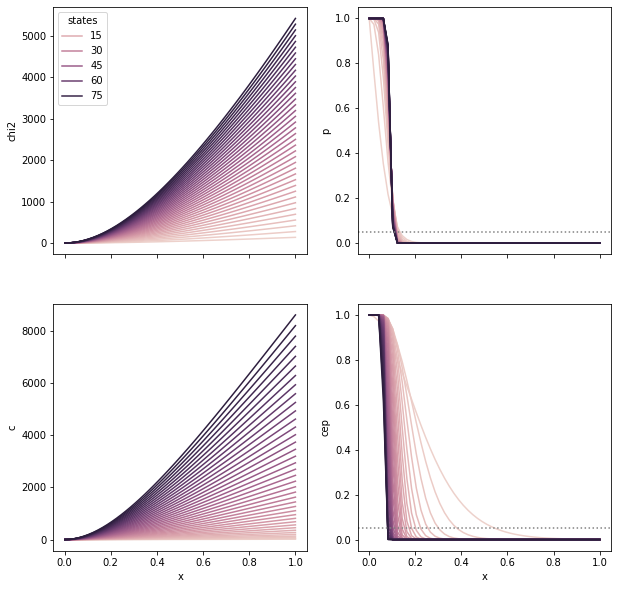

In [9]:
def state_hist_uniform(x, states):
    hists = [
        np.ones(states),
        np.concatenate([np.ones(int(states/2))*(1+x),np.ones(int(states/2))])]
    return np.array(hists)*obs

compare(np.linspace(0.001,1.0,50), range(2,80,2), state_hist_uniform, 'states')